In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# Mount Google Drive
drive.mount('/content/gdrive')

# Load data from Google Drive
df_A = pd.read_csv('/content/gdrive/MyDrive/CSE8803_Team2/Classification/Stress/Datasets/F_Relax_A_feature.csv', header=0)
df_M = pd.read_csv('/content/gdrive/MyDrive/CSE8803_Team2/Classification/Stress/Datasets/F_Relax_M_feature.csv', header=0)
df_S = pd.read_csv('/content/gdrive/MyDrive/CSE8803_Team2/Classification/Stress/Datasets/F_Relax_S_feature.csv', header=0)

# Fill missing values with the mode
df_A = df_A.fillna(df_A.mode().iloc[0])
df_M = df_M.fillna(df_M.mode().iloc[0])
df_S = df_S.fillna(df_S.mode().iloc[0])

# Drop the first column (assumed to be an index)
df_A = df_A.iloc[:, 1:]
df_M = df_M.iloc[:, 1:]
df_S = df_S.iloc[:, 1:]



Mounted at /content/gdrive


In [ ]:
# Perform feature selection and dimensionality reduction
def perform_feature_selection(df: pd.DataFrame, variance_threshold: float):
    y = df.iloc[:, -1]  # Target variable is the last column
    kept_columns_rfe = []  # List to store selected features
    start_column_index = 0

    for i in range(32):  # Assuming 32 EEG channels
        # Selecting features, excluding ratios (e.g., theta-beta ratio)
        X = df.iloc[:, list(range(start_column_index, start_column_index + 5)) + list(range(start_column_index + 8, start_column_index + 14))]
        curr_columns = X.columns

        # Recursive Feature Elimination with Cross Validation (RFECV)
        rfecv = RFECV(estimator=LogisticRegression(max_iter=10000), min_features_to_select=1, cv=StratifiedKFold(), scoring='accuracy', step=3)
        rfecv.fit(X, y)

        # Track the kept features
        kept_columns_rfe.extend(curr_columns[rfecv.support_])
        start_column_index += 14

    # After RFE, get the remaining features
    df_after_rfe = df[kept_columns_rfe]

    # Scaling the features
    scaler = StandardScaler()  # Scale the features
    scaled_X = scaler.fit_transform(df_after_rfe)

    # Apply PCA for dimensionality reduction (set to keep 95% variance)
    pca = PCA(n_components=variance_threshold)
    pca_result = pca.fit_transform(scaled_X)

    return pca_result, y  # Return PCA-transformed features and target labels






In [ ]:
# Apply feature selection and dimensionality reduction to the datasets
X_A, y_A = perform_feature_selection(df_A, variance_threshold=0.95)
X_M, y_M = perform_feature_selection(df_M, variance_threshold=0.95)
X_S, y_S = perform_feature_selection(df_S, variance_threshold=0.95)

Results for F_Relax_A:
Best Parameters: {'C': 10}
[[366 234]
 [220 380]]
              precision    recall  f1-score   support

           0       0.62      0.61      0.62       600
           1       0.62      0.63      0.63       600

    accuracy                           0.62      1200
   macro avg       0.62      0.62      0.62      1200
weighted avg       0.62      0.62      0.62      1200

Accuracy: 0.6216666666666667


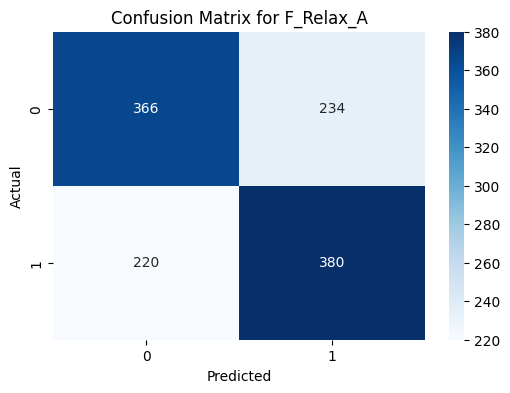

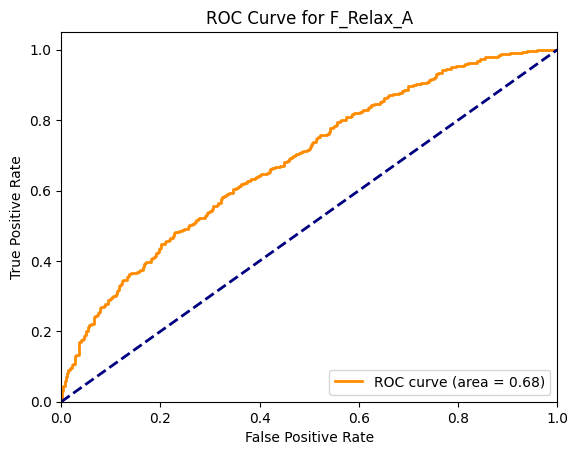

Results for F_Relax_M:
Best Parameters: {'C': 0.01}
[[319 281]
 [212 388]]
              precision    recall  f1-score   support

           0       0.60      0.53      0.56       600
           1       0.58      0.65      0.61       600

    accuracy                           0.59      1200
   macro avg       0.59      0.59      0.59      1200
weighted avg       0.59      0.59      0.59      1200

Accuracy: 0.5891666666666666


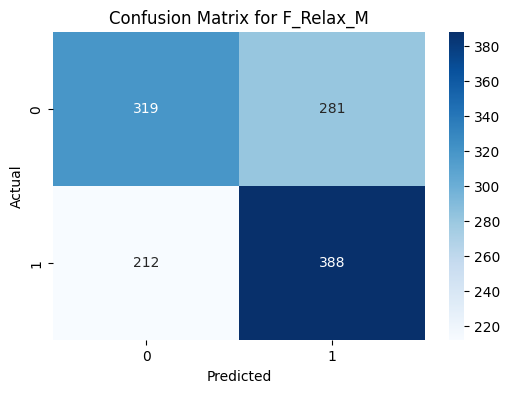

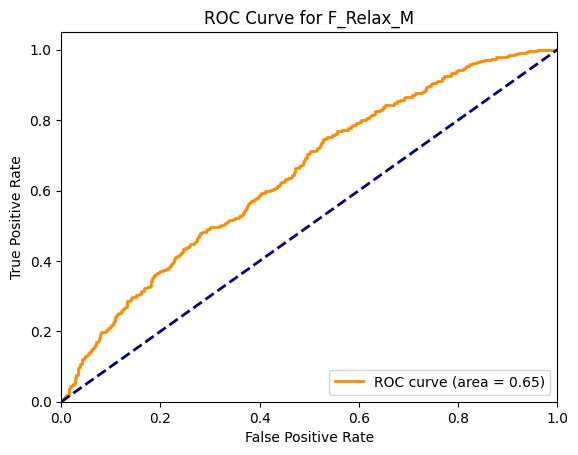

Results for F_Relax_S:
Best Parameters: {'C': 1}
[[388 212]
 [187 413]]
              precision    recall  f1-score   support

           0       0.67      0.65      0.66       600
           1       0.66      0.69      0.67       600

    accuracy                           0.67      1200
   macro avg       0.67      0.67      0.67      1200
weighted avg       0.67      0.67      0.67      1200

Accuracy: 0.6675


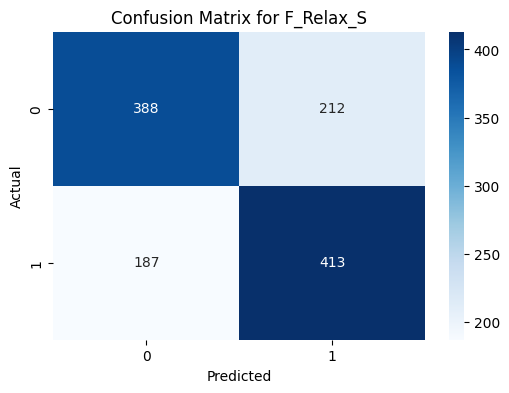

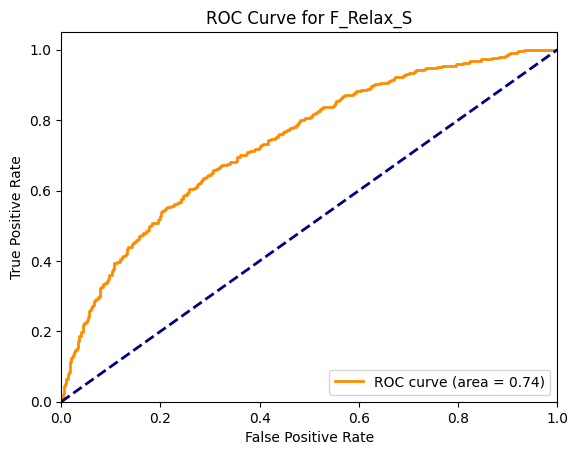

In [ ]:
# Function to build, tune, and evaluate the logistic regression model
def tune_and_evaluate_model(X, y, dataset_name):
    # Split data into training and testing sets (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Hyperparameter tuning with GridSearchCV
    param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
    grid_search = GridSearchCV(LogisticRegression(max_iter=10000), param_grid, cv=StratifiedKFold(), scoring='accuracy')
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_

    # Make predictions on test data
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Probability estimates for ROC

    # Print evaluation metrics
    print(f"Results for {dataset_name}:")
    print("Best Parameters:", grid_search.best_params_)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print("Accuracy:", accuracy_score(y_test, y_pred))

    # Confusion matrix heatmap
    plt.figure(figsize=(6,4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {dataset_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {dataset_name}')
    plt.legend(loc="lower right")
    plt.show()

# Evaluating on F_Relax_A, F_Relax_M, and F_Relax_S
tune_and_evaluate_model(X_A, y_A, "F_Relax_A")
tune_and_evaluate_model(X_M, y_M, "F_Relax_M")
tune_and_evaluate_model(X_S, y_S, "F_Relax_S")